In [18]:
import numpy as np
from PIL import Image
import os
import time
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## Pre-procesamiento de imágenes

Función para convertir imágenes a vectores normalizados en escala de grises:

In [19]:
def image_convert(dir, new_size):

    imagenes = []

    for filename in os.listdir(dir):

        file_path = os.path.join(dir, filename)
        
        if os.path.isfile(file_path):

            # Sin este if no funciona en mi windows, probar comentarlo en Mac a ver que pasa
            if not filename.lower().endswith('.png'):
                continue
            try:
                with Image.open(file_path) as img:
                    img = img.resize(new_size) 
                    img = img.convert('L') # Convertir a escala de grises
                    img_array = np.array(img)/255.0 # Convertir a array y normalizar
                    img_vector = img_array.reshape((new_size[0]**2)) 
                    imagenes.append(img_vector)
            except Exception as e:
                print(f"Error procesando la imagen {file_path}: {e}")

    return np.array(imagenes)


Configuramos los tamaños y elegimos aquel que se utilizará para los experimentos:

In [20]:
original = (256, 256)
mediano =  (128, 128)
chico = (64, 64)
muy_chico = (32, 32)

size = mediano

In [21]:
# Healthy
src_dir = 'DatasetTP/Healthy'
i_healthy = image_convert(src_dir, size) # Imágenes de pacientes sanos
d_healthy = np.ones((i_healthy.shape[0], 1)) * 0 # Vector de diagnósticos para la gente sana (0)

# Parkinson
src_dir = 'DatasetTP/Parkinson'  
i_park = image_convert(src_dir, size) # Imágenes de pacientes con Parkinson
d_park = np.ones((i_park.shape[0], 1)) # Vector de diagnósticos para la gente con Parkinson (1)

cant_healthy = i_healthy.shape[0] # Cantidad de imágenes sanas
print(f"Cantidad de imágenes sanas: {cant_healthy}")

cant_park = i_park.shape[0] # Cantidad de imágenes con Parkinson
print(f"Cantidad de imágenes con Parkinson: {cant_park}")

print(f"Tamaño de las imágenes: {size} = {size[0] * size[1]} pixeles")

Cantidad de imágenes sanas: 816
Cantidad de imágenes con Parkinson: 816
Tamaño de las imágenes: (128, 128) = 16384 pixeles


Separamos en conjuntos de entrenamiento y test:

In [22]:
cant_healthy_train = round(cant_healthy * 0.7) # 70% de las imágenes sanas para entrenamiento
cant_healthy_test = cant_healthy - cant_healthy_train # 30% de las imágenes sanas para test

cant_park_train = round(cant_park * 0.7) # 70% de las imágenes con Parkinson para entrenamiento
cant_park_test = cant_park - cant_park_train # 30% de las imágenes con Parkinson para test

print(f"Entrenamiento - Sanos: {cant_healthy_train}, Parkinson: {cant_park_train}")
print(f"Test - Sanos: {cant_healthy_test}, Parkinson: {cant_park_test}")

# Dividimos las imágenes en entrenamiento y test
i_train = np.vstack((i_healthy[:cant_healthy_train], i_park[:cant_park_train])) # Imágenes de entrenamiento
d_train = np.vstack((d_healthy[:cant_healthy_train], d_park[:cant_park_train])) # Diagnósticos de entrenamiento

i_test = np.vstack((i_healthy[cant_healthy_train:], i_park[cant_park_train:])) # Imágenes de test
d_test = np.vstack((d_healthy[cant_healthy_train:], d_park[cant_park_train:])) # Diagnósticos de test

print(f"Entrenamiento: {i_train.shape}, {d_train.shape}")
print(f"Test: {i_test.shape}, {d_test.shape}")

# Mezclo los datos de entrenamiento y test
np.random.seed(42)  
indices = np.random.permutation(i_train.shape[0])
i_train = i_train[indices]
d_train = d_train[indices]

indices = np.random.permutation(i_test.shape[0])
i_test = i_test[indices]
d_test = d_test[indices]

# Chequeamos que la intersección entre train y test sea nula (Importante)
print(len(set(map(tuple, i_train)).intersection(map(tuple, i_test))) == 0)


Entrenamiento - Sanos: 571, Parkinson: 571
Test - Sanos: 245, Parkinson: 245
Entrenamiento: (1142, 16384), (1142, 1)
Test: (490, 16384), (490, 1)
True


Queremos minimizar la función de pérdida:

$$
\sum_{i=1}^{N} \left( f^*(\mathbf{i}_i) - d_i \right)^2
$$

Es decir, queremos minimizar la diferencia entre los diagnósticos que predice el modelo y los reales. 

Buscamos la mejor solución dentro de las funciones $f : \mathbb{R}^K \to (0, 1)$
 que tengan la forma:

$$
f_{\mathbf{w}, b}(\mathbf{i}) = \frac{\tanh(\mathbf{w} \cdot \mathbf{i} + b) + 1}{2}
$$


donde $w$ es un vector de pesos (weights) de $\mathbb{R}^K$ , $b$ (bias) un escalar, y $tanh$ la tangente hiperbólica.

## Parte 1: Descenso de gradiente

$$
\arg\min_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b) = 
\arg\min_{\mathbf{w}, b} \sum_{i=1}^{N} \left( f_{\mathbf{w}, b}(\mathbf{i}_i) - d_i \right)^2
$$

Derivamos $\mathcal{L}$ con respecto a $b$ (bias) y $w$ (weight):

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial w} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)\cdot i
$$

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial b} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)
$$

Funciones base:

In [23]:
def fwb_desc(i, w, b):
    z = i@w + b 
    f = (np.tanh(z) + 1) / 2 
    return f 

In [24]:
# Error cuadrático total
def funcion_objetivo_desc(w, b, i, d):
    f = fwb_desc(i, w, b)
    return np.sum((f - d) ** 2)

In [25]:
# Derivada parcial respecto a w
def df_w_desc(w, b, i, d):
    # f = fwb_desc(i, w, b)
    z = i @ w + b
    f = (np.tanh(z) + 1) / 2
    dz = (1 - np.tanh(z) ** 2) * (f - d)  
    grad_w = i.T @ dz                  
    return grad_w

In [26]:
# Derivada parcial respecto a b
def df_b_desc(w, b, i, d):
    # f = fwb_desc(i, w, b)
    z = i @ w + b
    f = (np.tanh(z) + 1) / 2
    dz = (1 - np.tanh(z) ** 2) * (f - d)
    # grad_b = np.sum(dz, axis=0, keepdims=True)  # Da forma (1,1)
    grad_b = np.sum(dz) 
    return grad_b

In [27]:
def accuracy_desc(i, d, w, b):
    # true_positive = np.sum((f_opt >= 0.5) & (d_test == 1))
    # true_negative = np.sum((f_opt < 0.5) & (d_test == 0))
    # false_positive = np.sum((f_opt >= 0.5) & (d_test== 0))
    # false_negative = np.sum((f_opt < 0.5) & (d_test == 1))

    f = fwb_desc(i, w, b) >= 0.5 # Aplicamos la función de activación y comparamos con 0.5
    return np.mean(f == d) * 100  # Porcentaje de aciertos

## Descenso de gradiente

In [28]:
# MAX_ITER = 1000

# TOLERANCIA = 1e-7 

# def gradient_descent(w, b, imagenes_train, diagnosticos_train, imagenes_test, diagnosticos_test, alpha=0.1, normalizar=False):
    
#     if normalizar:
#       imagenes_train = imagenes_train / np.max(imagenes_train)
#       imagenes_test = imagenes_test / np.max(imagenes_test)

#     iter  = 0
#     valores_train = []
#     valores_test = []
#     acc_train = []
#     acc_test = []

#     while iter <= MAX_ITER:
        
#         loss_train = funcion_objetivo_desc(w, b, imagenes_train, diagnosticos_train)
#         print("Iteración: ", iter, "- Mínimo alcanzado hasta el momento: ", loss_train)

#         valores_train.append(loss_train)
#         acc_train.append(accuracy_desc(imagenes_train, diagnosticos_train, w, b))

#         valores_test.append(funcion_objetivo_desc(w, b, imagenes_test, diagnosticos_test))
#         acc_test.append(accuracy_desc(imagenes_test, diagnosticos_test, w, b)) 

#         gradiente_w = df_w_desc(w, b, imagenes_train, diagnosticos_train) 
#         gradiente_b = df_b_desc(w, b, imagenes_train, diagnosticos_train)

#         # Control de norma del gradiente
#         max_norm = 100.0
#         norm_w = np.linalg.norm(gradiente_w)
#         if norm_w > max_norm:
#             gradiente_w = gradiente_w * (max_norm / norm_w)

#         print("Norma gradiente_w:", np.linalg.norm(gradiente_w))
#         print("gradiente_b:", gradiente_b)
    
#         # # Si gradiente_b no es escalar, colapsar con promedio o suma
#         if gradiente_b.ndim > 0 and gradiente_b.size > 1:
#           gradiente_b = np.mean(gradiente_b)  # O np.sum(gradiente_b)

#         # Actualización 
#         w_sig = w - alpha * gradiente_w
#         b_sig = b - alpha * gradiente_b

#         # Criterio de convergencia
#         criterio = np.abs(funcion_objetivo_desc(w_sig, b_sig, imagenes_train, diagnosticos_train) - funcion_objetivo_desc(w, b, imagenes_train, diagnosticos_train))

#         if criterio < TOLERANCIA: # Converge
#           print("Criterio de convergencia alcanzado en iteración", iter)
#           break

#         w = w_sig
#         b = b_sig
#         iter += 1

#     return w_sig, b_sig, valores_train, valores_test, acc_train, acc_test

In [29]:
MAX_ITER = 1000

TOLERANCIA = 1e-7 

def gradient_descent(w, b, imagenes, diagnosticos, alpha=0.1, normalizar=False):
    
    if normalizar:
      imagenes = imagenes / np.max(imagenes)

    iter  = 0
    valores = []
    accuracy = []

    while iter <= MAX_ITER:
        
        loss = funcion_objetivo_desc(w, b, imagenes, diagnosticos)
        print("Iteración: ", iter, "- Mínimo alcanzado hasta el momento: ", loss)

        valores.append(loss)
        accuracy.append(accuracy_desc(imagenes, diagnosticos, w, b))
        
        gradiente_w = df_w_desc(w, b, imagenes, diagnosticos) 
        gradiente_b = df_b_desc(w, b, imagenes, diagnosticos)

        # Control de norma del gradiente
        max_norm = 100.0
        norm_w = np.linalg.norm(gradiente_w)
        if norm_w > max_norm:
            gradiente_w = gradiente_w * (max_norm / norm_w)

        print("Norma gradiente_w:", np.linalg.norm(gradiente_w))
        print("gradiente_b:", gradiente_b)
    
        # # Si gradiente_b no es escalar, colapsar con promedio o suma
        if gradiente_b.ndim > 0 and gradiente_b.size > 1:
          gradiente_b = np.mean(gradiente_b)  # O np.sum(gradiente_b)

        # Actualización 
        w_sig = w - alpha * gradiente_w
        b_sig = b - alpha * gradiente_b

        # Criterio de convergencia
        criterio = np.abs(funcion_objetivo_desc(w_sig, b_sig, imagenes, diagnosticos) - funcion_objetivo_desc(w, b, imagenes, diagnosticos))

        if criterio < TOLERANCIA: # Converge
          print("Criterio de convergencia alcanzado en iteración", iter)
          break

        w = w_sig
        b = b_sig
        iter += 1

    return w_sig, b_sig, valores, accuracy

Accuracy = (TP + TN) / (TP + TN + FP + FN)

## Entrenamiento

In [30]:
w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.01
b = np.random.uniform(-1, 1) * 0.01
alpha = 1e-7
normalizar = False

w_optimo, b_optimo, valores, acc = gradient_descent(w, b, i_train, d_train, alpha, normalizar)


Iteración:  0 - Mínimo alcanzado hasta el momento:  366.5100255745767
Norma gradiente_w: 100.0
gradiente_b: -219.62491488667817
Iteración:  1 - Mínimo alcanzado hasta el momento:  366.2769075277914
Norma gradiente_w: 100.0
gradiente_b: -219.56730386401364
Iteración:  2 - Mínimo alcanzado hasta el momento:  366.0438535513305
Norma gradiente_w: 100.0
gradiente_b: -219.5085602316509
Iteración:  3 - Mínimo alcanzado hasta el momento:  365.81086490209776
Norma gradiente_w: 99.99999999999999
gradiente_b: -219.44868181419298
Iteración:  4 - Mínimo alcanzado hasta el momento:  365.57794283940336
Norma gradiente_w: 100.00000000000001
gradiente_b: -219.38766644473384
Iteración:  5 - Mínimo alcanzado hasta el momento:  365.34508862495363
Norma gradiente_w: 100.0
gradiente_b: -219.32551196492668
Iteración:  6 - Mínimo alcanzado hasta el momento:  365.1123035228403
Norma gradiente_w: 100.00000000000001
gradiente_b: -219.2622162250529
Iteración:  7 - Mínimo alcanzado hasta el momento:  364.879588799

/var/folders/08/x3_1qxf96158s5_kxlxjblww0000gn/T/ipykernel_40773/3203713898.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


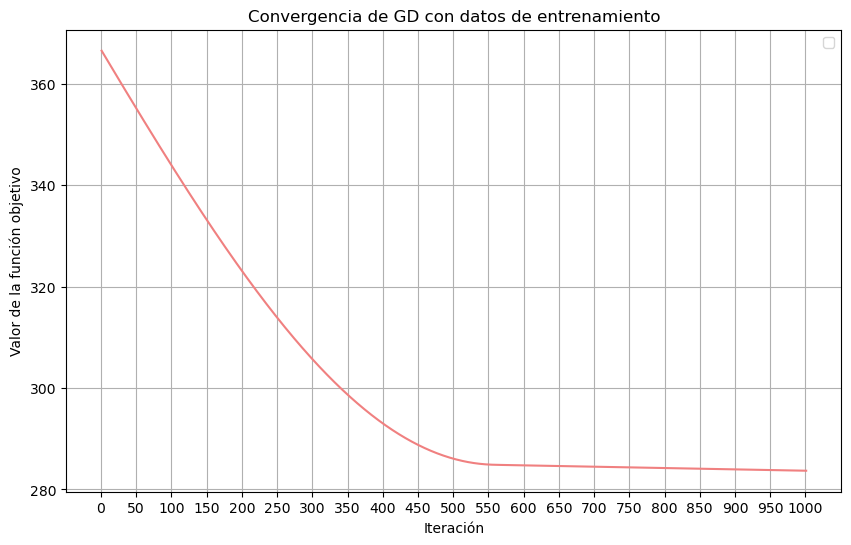

In [31]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(valores) + 1), valores, linestyle='-', color='lightcoral')

tick_interval = max(1, len(valores) // 20)
plt.xticks(np.arange(0, len(valores) + 1, step=tick_interval))

plt.xlabel('Iteración')
plt.ylabel('Valor de la función objetivo')
plt.title('Convergencia de GD con datos de entrenamiento')
plt.grid(True)
plt.legend()  
plt.show()


/var/folders/08/x3_1qxf96158s5_kxlxjblww0000gn/T/ipykernel_40773/4266408135.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/08/x3_1qxf96158s5_kxlxjblww0000gn/T/ipykernel_40773/4266408135.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


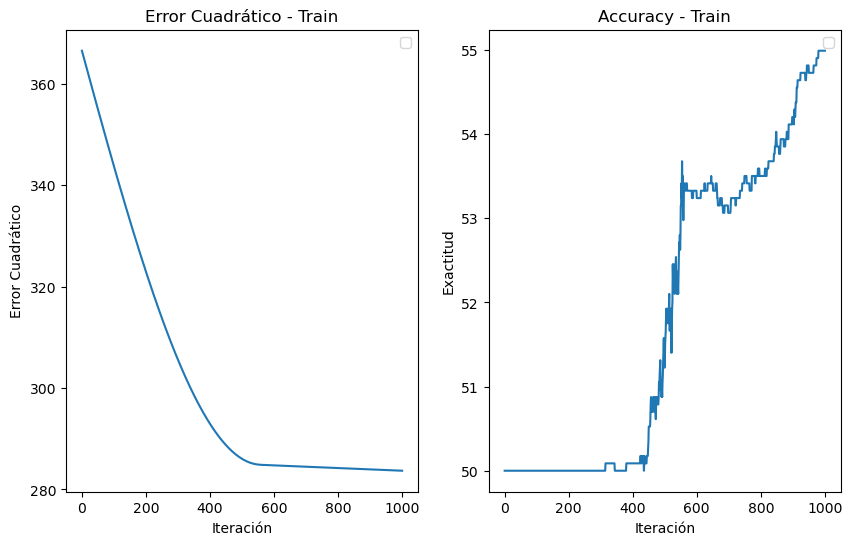

In [32]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.plot(valores)
plt.title('Error Cuadrático - Train')
plt.xlabel('Iteración')
plt.ylabel('Error Cuadrático')
plt.legend()

plt.subplot(1,2,2)
plt.plot(acc)
plt.title('Accuracy - Train')
plt.xlabel('Iteración')
plt.ylabel('Exactitud')
plt.legend()

plt.show()

## Testeo

In [33]:
w = np.random.uniform(-1, 1, (i_test.shape[1], 1)) * 0.01
b = np.random.uniform(-1, 1) * 0.01
alpha = 1e-7
normalizar = False

w_optimo, b_optimo, valores, acc = gradient_descent(w, b, i_test, d_test, alpha, normalizar)

Iteración:  0 - Mínimo alcanzado hasta el momento:  141.6338576939799
Norma gradiente_w: 100.0
gradiente_b: 79.58176198802727
Iteración:  1 - Mínimo alcanzado hasta el momento:  141.5498815447757
Norma gradiente_w: 100.0
gradiente_b: 79.46833361506408
Iteración:  2 - Mínimo alcanzado hasta el momento:  141.4660236992989
Norma gradiente_w: 100.0
gradiente_b: 79.35437229452278
Iteración:  3 - Mínimo alcanzado hasta el momento:  141.3822847327291
Norma gradiente_w: 100.00000000000001
gradiente_b: 79.23987800537907
Iteración:  4 - Mínimo alcanzado hasta el momento:  141.2986652202809
Norma gradiente_w: 100.00000000000001
gradiente_b: 79.12485073328176
Iteración:  5 - Mínimo alcanzado hasta el momento:  141.21516573719637
Norma gradiente_w: 99.99999999999999
gradiente_b: 79.00929047057086
Iteración:  6 - Mínimo alcanzado hasta el momento:  141.13178685873748
Norma gradiente_w: 99.99999999999999
gradiente_b: 78.89319721629465
Iteración:  7 - Mínimo alcanzado hasta el momento:  141.0485291601

/var/folders/08/x3_1qxf96158s5_kxlxjblww0000gn/T/ipykernel_40773/3767553105.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


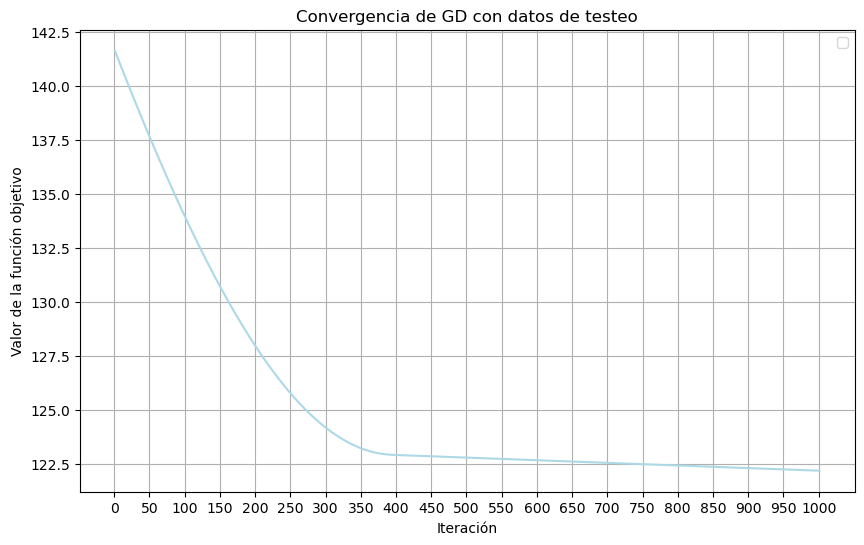

In [34]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(valores) + 1), valores, linestyle='-', color='lightblue')

tick_interval = max(1, len(valores) // 20)
plt.xticks(np.arange(0, len(valores) + 1, step=tick_interval))

plt.xlabel('Iteración')
plt.ylabel('Valor de la función objetivo')
plt.title('Convergencia de GD con datos de testeo')
plt.grid(True)
plt.legend()  
plt.show()

/var/folders/08/x3_1qxf96158s5_kxlxjblww0000gn/T/ipykernel_40773/1454424170.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/08/x3_1qxf96158s5_kxlxjblww0000gn/T/ipykernel_40773/1454424170.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


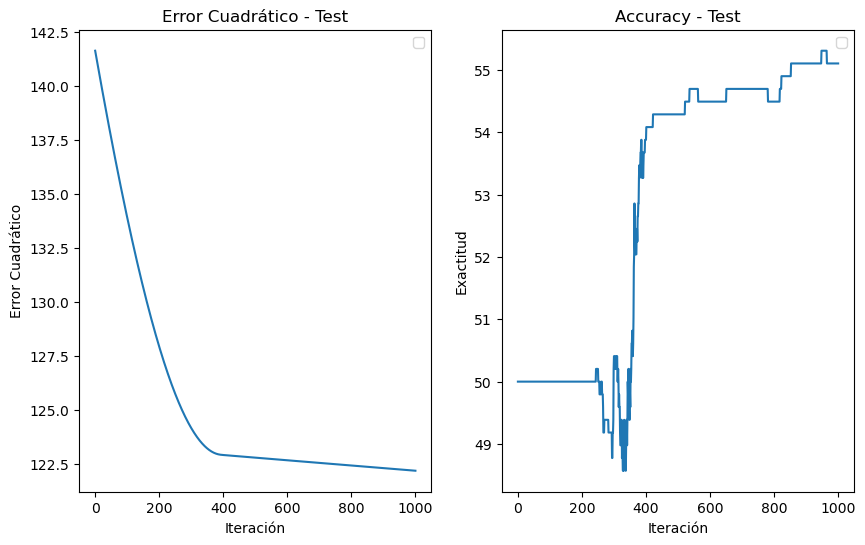

In [35]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.plot(valores)
plt.title('Error Cuadrático - Test')
plt.xlabel('Iteración')
plt.ylabel('Error Cuadrático')
plt.legend()

plt.subplot(1,2,2)
plt.plot(acc)
plt.title('Accuracy - Test')
plt.xlabel('Iteración')
plt.ylabel('Exactitud')
plt.legend()

plt.show()

### Matriz de confusión

## Parte 2: Ascenso de gradiente

$$

\arg\min_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b) = - \sum_{i=1}^{N} \left[ d_i \log\left( f_{\mathbf{w}, b}(\mathbf{i} * i) \right) + (1 - d_i) \log\left( 1 - f * \mathbf{w}, b(\mathbf{i}_i) \right) \right]


$$

In [36]:
def fwb_asc(i, w, b):
    z = i@w + b 
    f = 1 / (1 + np.exp(-z))  
    return f

In [37]:
def funcion_objetivo_asc(w, b, i, d):
    f = fwb_asc(i, w, b)
    epsilon = 1e-15
    f = np.clip(f, epsilon, 1 - epsilon)
    return -np.sum(d * np.log(f) + (1 - d) * np.log(1 - f))  

In [38]:
def df_w_asc(w, b, i, d):
    t1 = fwb_asc(i,w,b) 
    t0 = 1 - t1

    if t1 == 0 or t1 == 1:
        t1 = np.clip(t1, 1e-12, 1 - 1e-12) # Número muy pequeño para evitar división por cero
        t0 = 1 - t1

    term1 = (d * t0) / t1 * i
    term2 = ((1 - d) * t1) / (t0 * t1 * (1 - 1 / t1)) * i
    grad = term1 - term2
    return grad

# Versión de chat más simple
# def df_w_asc(w, b, i, d):
#     f = fwb_asc(i, w, b)
#     return np.dot((f - d), i)

In [39]:
def df_b_asc(w, b, i, d):
    t1 = fwb_asc(i,w,b) 
    t0 = 1 - t1

    if t1 == 0 or t1 == 1:
        t1 = np.clip(t1, 1e-12, 1 - 1e-12) # Número muy pequeño para evitar división por cero
        t0 = 1 - t1

    term1 = (d * t0) / t1
    term2 = (t0 * (1 - d)) / (t1**2 * (1 - 1 / t1))
    grad = term1 - term2
    return grad

# Versión de chat más simple
# def df_b_asc(w, b, i, d):
#     f = fwb_asc(i, w, b)
#     return np.sum(f - d)

Ejercicio 3

In [42]:
MAX_ITER = 1000
TOLERANCIA = 1e-7

def gradiente_ascendente(w, b, imagenes_train, diagnosticos_train,imagenes_test, diagnosticos_test,alpha):

    loss_train, loss_test = [], []
    acc_train, acc_test = [], []

    iter = 0
    converge = False

    while iter < MAX_ITER and not converge:
        # Gradientes (usando tus funciones)
        grad_w = df_w_asc(w, b, i_train, d_train)
        grad_b = df_b_asc(w, b, i_train, d_train)

        # Actualización ascendente
        w += alpha * grad_w
        b += alpha * grad_b

        # Evaluación en train
        f_train = np.clip(fwb_asc(i_train, w, b), 1e-15, 1 - 1e-15)
        loss_train.append(funcion_objetivo_asc(w, b, i_train, d_train))
        acc_train.append(np.mean((f_train >= 0.5) == d_train))

        # Evaluación en test
        f_test = np.clip(fwb_asc(i_test, w, b), 1e-15, 1 - 1e-15)
        loss_test.append(funcion_objetivo_asc(w, b, i_test, d_test))
        acc_test.append(np.mean((f_test >= 0.5) == d_test))

        # Verificar convergencia
        if np.linalg.norm(alpha * grad_w) < TOLERANCIA and abs(alpha * grad_b) < TOLERANCIA:
            converge = True

        print(f"Iteración: {iter}, Pérdida Train: {loss_train[-1]}, Pérdida Test: {loss_test[-1]}, "f"Accuracy Train: {acc_train[-1]}, Accuracy Test: {acc_test[-1]}")
        iter += 1

    return w, b, loss_train, loss_test, acc_train, acc_test